In [165]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt

In [193]:
class ROC:
    """
    ROC curve builder class.
    Classes are assumed to be binary

    """
    # results is an numpy array formed by stacking together fpr, tpr and corresponding thresholds.
    # use results for analysis
    results = None

    def __init__(self, proba, true_labels, pos_label_value, pos_label=1):
        """
        Use these values in calc_tpr_fpr() method

        :param proba: numpy array of class probabilities
        :param true_labels: numpy array of true labels
        :param pos_label_value: The value of the positive label (usually 1)
        :param pos_label: The relative order of positive label in proba
        """
        sortargs = proba.argsort()[::-1]
        self.proba = proba[sortargs]
        self.true_labels = true_labels[sortargs]
        self.pos_label_value = pos_label_value
        self.pos_label = pos_label

    def plot(self):
        """
        Plots an ROC curve using True Positive Rate and False Positive rate lists calculated from __calc_tpr_fpr
        Calculates and outputs AUC score on the same graph
        """
        tpr, fpr, thresholds, area = self.__calc_tpr_fpr()
        self.results = np.column_stack((tpr, fpr, thresholds))

        # %%% TODO START YOUR CODE HERE %%%
        plt.plot(fpr, tpr, label='ROC curve of class 1. Area={:.3f}'.format(area))
        plt.legend()
        plt.show()
        # %%% END YOUR CODE HERE %%%

    def __calc_tpr_fpr(self):
        """
        Calculates True Positive Rate, False Positive Rate and thresholds lists

        First, sorts probabilities of positive label in decreasing order
        Next, moving towards the least probability locates a threshold between instances with opposite classes
        (keeping instances with the same confidence value on the same side of threshold),
        computes TPR, FPR for instances above threshold and puts them in the lists

        :return:
        tpr: list
        fpr: list
        thresholds: list
        """
        # %%% TODO START YOUR CODE HERE %%%
        total_p = self.true_labels[self.true_labels==1].size
        total_n = self.true_labels[self.true_labels==0].size
        tpr = [0]
        fpr = [0]
        thresholds = [1]
#         for i, item in enumerate(zip(self.proba, self.true_labels)):
#             if i==0:
#                 continue
        crnt_lbl = 1
        area = 0
        printt = False
        for i,y in enumerate(self.true_labels):
            if y!=crnt_lbl:
                crnt_lbl = y
                new_fpr = self.true_labels[:i][self.true_labels[:i]==0].size/total_n
                new_tpr = self.true_labels[:i][self.true_labels[:i]==1].size/total_p
                area += (new_fpr-fpr[-1])*new_tpr
                fpr += [new_fpr]
                tpr += [new_tpr]
                thresholds += [self.proba[i]]
                if self.proba[i] <= .6 and not printt:
                    print('threshold =', self.proba[i])
                    print('fpr =', new_fpr)
                    print('tpr =', new_tpr)
                    printt = True
            else:
                continue
        new_fpr = 1
        new_tpr = tpr[-1]
        area += (new_fpr-fpr[-1])*new_tpr
        fpr += [new_fpr]
        tpr += [new_tpr]
        thresholds += [0]
        return tpr, fpr, thresholds, area
        # %%% END YOUR CODE HERE %%%

In [127]:
def stratified_train_test_split(X, Y, test_size, random_seed=10):
    """
    Performs the stratified train/test split
    (with the same (!) inter-class ratio in train and test sets as compared to original set)
    input:
        X: numpy array of size (n,m)
        Y: numpy array of size (n,)
        test_size: number between 0 and 1, specifies the relative size of the test_set
        random_seed: random_seed

    returns:
        X_train
        X_test
        Y_train
        Y_test
    """
    if test_size < 0 or test_size > 1:
        raise Exception("Fraction for split is not valid")

    np.random.seed(random_seed)

    # %%% TODO START YOUR CODE HERE %%%

    positive_idx = np.where(Y==1)[0]
    negative_idx = np.where(Y==0)[0]
    m = Y.size
    m_test = int(m*test_size)
    m_pos_test = int(test_size*positive_idx.size)
    m_neg_test = m_test-m_pos_test
    
    test_idx_pos = np.random.choice(positive_idx, m_pos_test, replace=False)
    test_idx_neg = np.random.choice(negative_idx, m_neg_test, replace=False)
    train_idx_pos = positive_idx[np.where(~np.isin(positive_idx, test_idx_pos))[0]]
    train_idx_neg = negative_idx[np.where(~np.isin(negative_idx, test_idx_neg))[0]]
    train_idx = np.append(train_idx_pos, train_idx_neg)

    train_idx = np.random.choice(train_idx, train_idx.size, replace=False)
    test_idx = np.append(test_idx_pos, test_idx_neg)
    test_idx = np.random.choice(test_idx, m_test, replace=False)
    train_Y = Y[train_idx]
    train_X = X[train_idx]
    test_Y = Y[test_idx]
    test_X = X[test_idx]
    return train_X, test_X, train_Y, test_Y
    # %%% END YOUR CODE HERE %%%

In [128]:
data = load_breast_cancer()

In [129]:
# Pre-processing: Exchange labels - make malignant 1, benign 0
data['target'] = np.array(data['target'], dtype=int) ^ 1

In [130]:
Y = data['target']
X = data['data']

In [131]:
X_train, X_test, y_train, y_test = stratified_train_test_split(X, Y, .3, 10)

In [132]:
# Check that the ratio is preserved
print("Inter-class ratio in original set:", len(np.argwhere(data['target'] == 1))/len(np.argwhere(data['target'] == 0)))
print("Inter-class ratio in train set:", len(np.argwhere(y_train == 1))/len(np.argwhere(y_train == 0)))
print("Inter-class ratio in test set:", len(np.argwhere(y_test == 1))/len(np.argwhere(y_test == 0)))
print('\n')

Inter-class ratio in original set: 0.5938375350140056
Inter-class ratio in train set: 0.596
Inter-class ratio in test set: 0.5887850467289719




In [168]:
# We pick Logistic Regression because it outputs probabilities
# Try different number of iterations to change ROC curve
model = LogisticRegression(max_iter=5)
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)
y_pred = model.predict(X_test)
print("Classifier's Accuracy:", accuracy_score(y_test, y_pred))

Classifier's Accuracy: 0.929411764706


threshold = 0.55912330929
fpr = 0.018691588785046728
tpr = 0.8888888888888888


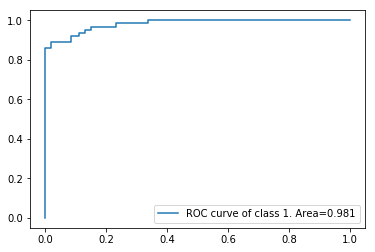

In [194]:
# Build an ROC curve
roc = ROC(probabilities[:,1], y_test, 1)
roc.plot()

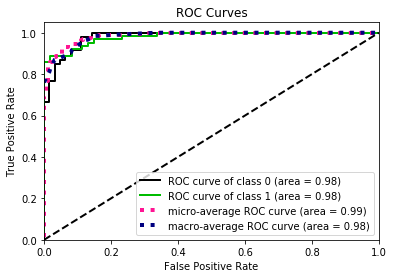

In [171]:
# Explore the results
results = roc.results

# Use scikitplot library to compare ROC curve with the one you are getting
skplt.metrics.plot_roc_curve(y_test, probabilities)
plt.show()


# ROC analysis questions:
# 1. What are fpr, tpr rates if we choose 0.5 as a threshold?
# according to data printed above, fpr = 0.019, tpr = 0.89

# 2. Let's suppose this is a second cancer check for those who have high probability of cancer.
#   What threshold value will you use in this case and why?

# The threshold should be higher than before, as the probability of double fault (classifying healthy patient as ill) is low